<h1> Natality: Predict weight of a newborn</h1>
<h2> Creating a sampled dataset </h2>

This notebook illustrates:
<ol>
<li> Sampling a BigQuery dataset to create datasets for ML
<li> Preprocessing with Pandas
</ol>

In [1]:
# change these to try this notebook out
BUCKET = 'GCP-bucket-name'
PROJECT = 'GCP-project-Name'
REGION = 'zone' #see gcloud compute zones list

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [3]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
  gsutil mb -l ${REGION} gs://${BUCKET}
fi

<h2> Explore full Natality dataset using BigQuery </h2>
<p>
Let's evaluate the dataset before sample for ML
</p>

In [16]:
import pandas as pd
from scipy.stats import zscore

pd.set_option("display.max_rows",101)
pd.set_option("display.max_columns",101)

In [17]:
query = """
            SELECT
              *
            FROM
              publicdata.samples.natality
            WHERE
              year > 2000
"""

import google.datalab.bigquery as bq
natality = bq.Query("SELECT * FROM (" + query + ") WHERE RAND() < 0.0001").execute().result().to_dataframe()

In [18]:
natality.describe(include = 'all')

,source_year,year,month,day,wday,state,is_male,child_race,weight_pounds,plurality,apgar_1min,apgar_5min,mother_residence_state,mother_race,mother_age,gestation_weeks,lmp,mother_married,mother_birth_state,cigarette_use,cigarettes_per_day,alcohol_use,drinks_per_week,weight_gain_pounds,born_alive_alive,born_alive_dead,born_dead,ever_born,father_race,father_age,record_weight
count,3281.000000,3281.000000,3281.000000,0.0,3281.000000,1605,3281,821.0,3279.000000,3281.000000,821.0,2983.000000,1605,2272.000000,3281.000000,3264.000000,3281,3281,1599,1329,134.000000,2040,115.000000,3227.000000,2017.000000,2014.000000,2016.000000,3269.000000,2272.000000,3281.000000,3281.0
unique,NaN,NaN,NaN,0.0,NaN,50,2,NaN,NaN,NaN,NaN,NaN,50,NaN,NaN,NaN,1934,2,58,2,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,CA,True,NaN,NaN,NaN,NaN,NaN,CA,NaN,NaN,NaN,99999999,True,CA,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,205,1679,NaN,NaN,NaN,NaN,NaN,204,NaN,NaN,NaN,158,2048,127,1195,NaN,1901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2004.520878,2004.520878,6.517220,NaN,3.999086,NaN,NaN,9.0,7.234834,1.032917,99.0,14.724438,NaN,2.941461,27.268820,38.630208,NaN,NaN,NaN,NaN,18.537313,NaN,2.686957,42.543849,1.070402,0.020854,0.389385,2.076476,14.102993,40.757086,1.0
std,2.292008,2.292008,3.436146,NaN,1.841344,NaN,NaN,0.0,1.311218,0.190030,0.0,22.244326,NaN,10.422582,6.102801,2.581830,NaN,NaN,NaN,NaN,28.426837,NaN,15.844843,27.863945,1.227173,0.177083,0.820740,1.238272,31.743370,25.314927,0.0
min,2001.000000,2001.000000,1.000000,NaN,1.000000,NaN,NaN,9.0,0.562179,1.000000,99.0,0.000000,NaN,1.000000,14.000000,18.000000,NaN,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,15.000000,1.0
25%,2002.000000,2002.000000,4.000000,NaN,2.000000,NaN,NaN,9.0,6.563162,1.000000,99.0,9.000000,NaN,1.000000,22.000000,38.000000,NaN,NaN,NaN,NaN,5.000000,NaN,0.000000,25.000000,0.000000,0.000000,0.000000,1.000000,1.000000,26.000000,1.0
50%,2005.000000,2005.000000,7.000000,NaN,4.000000,NaN,NaN,9.0,7.312733,1.000000,99.0,9.000000,NaN,1.000000,27.000000,39.000000,NaN,NaN,NaN,NaN,8.500000,NaN,0.000000,34.000000,1.000000,0.000000,0.000000,2.000000,1.000000,32.000000,1.0
75%,2007.000000,2007.000000,9.000000,NaN,6.000000,NaN,NaN,9.0,8.000575,1.000000,99.0,9.000000,NaN,1.000000,32.000000,40.000000,NaN,NaN,NaN,NaN,20.000000,NaN,0.000000,49.500000,2.000000,0.000000,0.000000,3.000000,2.000000,39.000000,1.0


There are over 31 columns with a mix of categorical, boolean, and numerical (nominal and interval). Here are some notable insights from the description of the columns:
*  The "day" column is empty
*  Although cigarette use would be an interesting feature to dive deeper into, their lack of entries limits their utility, and it is also is an example of possible response bias. This is similar for both "alcohol_use" and "drinks_per_week"
*  The "father_race", "father_age", "drinks_per_week", "weight_gain_pounds", "cigarettes_per_day", "apgar_1min", and "apgar_5min" columns seem to have imputed missing values with 99
*  There seems to be an error in "mother_race" as the value 78 does not refer to any race in the codebook


In [24]:
natality_corr = natality.corr(min_periods = 50)
natality_corr.sort_values(by = ["weight_pounds"], ascending=False, inplace=True)
natality_corr

,source_year,year,month,wday,is_male,child_race,weight_pounds,plurality,apgar_1min,apgar_5min,mother_race,mother_age,gestation_weeks,mother_married,cigarettes_per_day,drinks_per_week,weight_gain_pounds,born_alive_alive,born_alive_dead,born_dead,ever_born,father_race,father_age,record_weight
weight_pounds,-0.031654,-0.031654,-0.018221,-0.007352,0.100693,NaN,1.000000,-0.295961,NaN,0.030203,-0.016242,0.094301,0.539412,0.128734,0.069094,0.057672,0.048080,0.061612,-0.041102,-0.024513,0.046624,-0.037104,-0.063675,NaN
gestation_weeks,-0.020197,-0.020197,-0.009340,-0.001679,-0.012215,NaN,0.539412,-0.262976,NaN,-0.005245,0.024157,-0.001194,1.000000,0.039806,0.042263,0.024803,0.003356,-0.047917,-0.037601,-0.067928,-0.047118,0.008888,-0.042219,NaN
mother_married,-0.047714,-0.047714,-0.034851,0.026959,0.023880,NaN,0.128734,0.031751,NaN,0.006163,0.067297,0.453928,0.039806,1.000000,0.012922,0.102231,-0.009328,0.065241,-0.033308,0.024112,0.052984,-0.385408,-0.412853,NaN
is_male,-0.015313,-0.015313,-0.004865,-0.016713,1.000000,NaN,0.100693,-0.020113,NaN,0.002981,-0.007616,0.009958,-0.012215,0.023880,-0.089836,-0.046895,0.017601,0.001966,-0.060342,-0.028452,-0.005410,0.009375,0.009078,NaN
mother_age,-0.010471,-0.010471,-0.035056,-0.002501,0.009958,NaN,0.094301,0.054673,NaN,0.005443,0.071221,1.000000,-0.001194,0.453928,0.084871,-0.084010,0.014590,0.311000,0.013893,0.194886,0.307869,-0.160923,-0.069648,NaN
cigarettes_per_day,-0.232307,-0.232307,-0.135037,-0.072928,-0.089836,NaN,0.069094,0.178039,NaN,0.066922,-0.032548,0.084871,0.042263,0.012922,1.000000,0.346794,0.050624,0.231472,-0.088741,0.189315,0.141352,-0.127913,-0.100863,NaN
born_alive_alive,-0.015249,-0.015249,-0.013077,0.016947,0.001966,NaN,0.061612,0.059460,NaN,0.033610,0.012707,0.311000,-0.047917,0.065241,0.231472,0.092146,0.027735,1.000000,0.059407,0.155024,0.989962,0.008353,0.071979,NaN
drinks_per_week,-0.205771,-0.205771,-0.098143,-0.037423,-0.046895,NaN,0.057672,-0.015952,NaN,0.009906,-0.004914,-0.084010,0.024803,0.102231,0.346794,1.000000,-0.063128,0.092146,-0.023849,-0.100823,0.076289,-0.100344,-0.090691,NaN
weight_gain_pounds,-0.114866,-0.114866,0.001419,0.025886,0.017601,NaN,0.048080,0.068484,NaN,0.369079,-0.018349,0.014590,0.003356,-0.009328,0.050624,-0.063128,1.000000,0.027735,0.001679,-0.028469,-0.001812,-0.001526,-0.009218,NaN
ever_born,-0.023700,-0.023700,-0.004279,-0.010293,-0.005410,NaN,0.046624,0.050289,NaN,0.031905,-0.017265,0.307869,-0.047118,0.052984,0.141352,0.076289,-0.001812,0.989962,0.199898,0.162821,1.000000,0.003989,0.091037,NaN


According to the Pearson correlation coefficients, the best features are gestation_weeks, mother_married, is_male, and mother_age for the numerical columns. From domain knowledge of child births, plurality is also selected as a strong feature for predicting the weight of newborns.

Let's continue exploring the data through simple, but effective visualizations.

/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


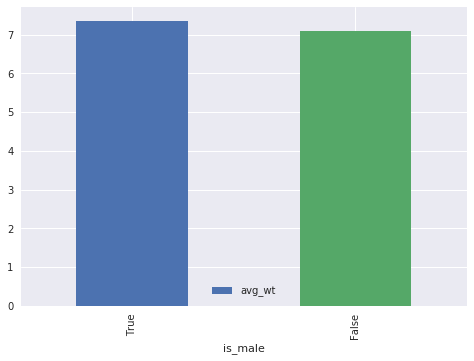

In [25]:
def get_distinct_values(column_name):
  sql = """
SELECT
  {0},
  COUNT(1) AS num_babies,
  AVG(weight_pounds) AS avg_wt
FROM
  publicdata.samples.natality
WHERE
  year > 2000
GROUP BY
  {0}
  """.format(column_name)
  return bq.Query(sql).execute().result().to_dataframe()

df = get_distinct_values('is_male')
df.plot(x='is_male', y='avg_wt', kind='bar');

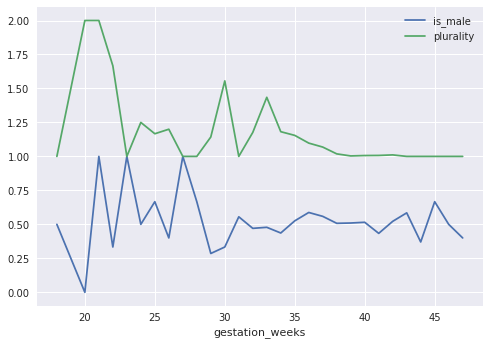

In [26]:
gestation_weeks_vs_other = natality.groupby(["gestation_weeks"]).mean()[["is_male","plurality"]]
gestation_weeks_vs_other.plot.line()

In [29]:
natality[natality["gestation_weeks"]==20].describe(include="all")

,source_year,year,month,day,wday,state,is_male,child_race,weight_pounds,plurality,apgar_1min,apgar_5min,mother_residence_state,mother_race,mother_age,gestation_weeks,lmp,mother_married,mother_birth_state,cigarette_use,cigarettes_per_day,alcohol_use,drinks_per_week,weight_gain_pounds,born_alive_alive,born_alive_dead,born_dead,ever_born,father_race,father_age,record_weight
count,2.0,2.0,2.0,0.0,2.0,0.0,2,0.0,2.000000,2.0,0.0,2.0,0.0,2.0,2.0,2.0,2,2,0.0,2,0.0,2,0.0,2.0,0.0,0.0,0.0,2.000000,2.0,2.0,2.0
unique,NaN,NaN,NaN,0.0,NaN,0.0,1,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1,1,0.0,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,05992006,False,NaN,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,NaN,2,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2006.0,2006.0,9.0,NaN,7.0,NaN,NaN,NaN,0.906100,2.0,NaN,0.0,NaN,2.0,17.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,1.500000,2.0,18.0,1.0
std,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,0.043649,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.707107,0.0,0.0,0.0
min,2006.0,2006.0,9.0,NaN,7.0,NaN,NaN,NaN,0.875235,2.0,NaN,0.0,NaN,2.0,17.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,1.000000,2.0,18.0,1.0
25%,2006.0,2006.0,9.0,NaN,7.0,NaN,NaN,NaN,0.890668,2.0,NaN,0.0,NaN,2.0,17.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,1.250000,2.0,18.0,1.0
50%,2006.0,2006.0,9.0,NaN,7.0,NaN,NaN,NaN,0.906100,2.0,NaN,0.0,NaN,2.0,17.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,1.500000,2.0,18.0,1.0
75%,2006.0,2006.0,9.0,NaN,7.0,NaN,NaN,NaN,0.921532,2.0,NaN,0.0,NaN,2.0,17.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,1.750000,2.0,18.0,1.0


There is sparsity in the data as can be seen in the above line plot and table. At gestation weeks of 20, there are only two records, both of which are twin female newborn births.

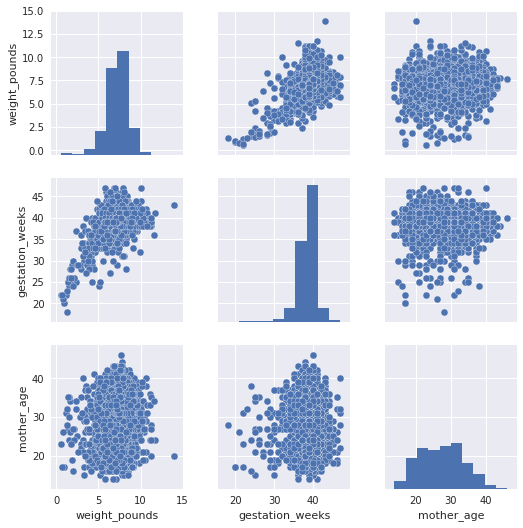

In [32]:
import seaborn as sns
sns.pairplot(natality[["weight_pounds","gestation_weeks","mother_age"]].dropna())

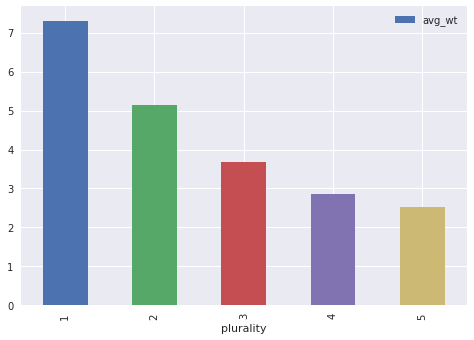

In [33]:
df = get_distinct_values('plurality')
df = df.sort_values('plurality')
df.plot(x='plurality', y='avg_wt', kind='bar');

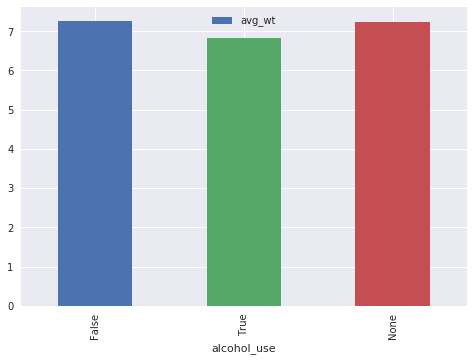

In [34]:
df = get_distinct_values('alcohol_use')
df = df.sort_values('alcohol_use')
df.plot(x='alcohol_use', y='avg_wt', kind='bar');

<h2> Create ML dataset by sampling using BigQuery </h2>
<p>
Let's sample the BigQuery data to create smaller datasets.
</p>

In [4]:
# Create SQL query using natality data after the year 2000
import google.datalab.bigquery as bq
query = """
SELECT
  weight_pounds,
  is_male,
  mother_age,
  plurality,
  gestation_weeks,
  mother_married,
  FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING), CAST(wday AS STRING))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE year > 2000
"""

There are only a limited number of years and months in the dataset. Let's see what the hashmonths are.

In [5]:
# Call BigQuery but GROUP BY the hashmonth and see number of records for each group to enable us to get the correct train and evaluation percentages
df = bq.Query("SELECT hashmonth, COUNT(weight_pounds) AS num_babies FROM (" + query + ") GROUP BY hashmonth").execute().result().to_dataframe()
print("There are {} unique hashmonths.".format(len(df)))
df.head()

There are 672 unique hashmonths.


,hashmonth,num_babies
0,3567934916849143973,50688
1,8502900579502152792,52992
2,1671153752880571251,59392
3,-6663129674444867382,60672
4,6441112521155172543,47105


Here's a way to get a well distributed portion of the data in such a way that the test and train sets do not overlap:

In [6]:
# Added the RAND() so that we can now subsample from each of the hashmonths to get approximately the record counts we want
trainQuery = "SELECT * FROM (" + query + ") WHERE MOD(hashmonth, 4) < 3 AND RAND() < 0.001"
evalQuery = "SELECT * FROM (" + query + ") WHERE MOD(hashmonth, 4) = 3 AND RAND() < 0.0015"
traindf = bq.Query(trainQuery).execute().result().to_dataframe()
evaldf = bq.Query(evalQuery).execute().result().to_dataframe()
print("There are {} examples in the train dataset and {} in the eval dataset".format(len(traindf), len(evaldf)))

There are 28644 examples in the train dataset and 7062 in the eval dataset


<h2> Preprocess data using Pandas </h2>
<p>
Let's add extra rows to simulate the lack of ultrasound. In the process, we'll also change the plurality column to be a string.

In [7]:
traindf.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,mother_married,hashmonth
0,6.294198,True,15,1,NaN,False,5196045867830167686
1,6.999677,False,15,1,NaN,True,-6718872612173142345
2,6.750554,True,16,1,NaN,False,8486568935975462149
3,6.933538,False,16,1,NaN,False,-5725309102206228019
4,6.314039,False,16,1,NaN,False,-7901005608806392424


Also notice that there are some very important numeric fields that are missing in some rows (the count in Pandas doesn't count missing data)

In [8]:
# Let's look at a small sample of the training data
traindf.describe()

,weight_pounds,mother_age,plurality,gestation_weeks,hashmonth
count,28617.000000,28644.000000,28644.000000,28406.000000,2.864400e+04
mean,7.229129,27.290148,1.035051,38.628459,-5.161007e+17
std,1.313827,6.132353,0.193170,2.578346,5.247425e+18
min,0.500449,12.000000,1.000000,17.000000,-9.153539e+18
25%,6.563162,22.000000,1.000000,38.000000,-4.924562e+18
50%,7.312733,27.000000,1.000000,39.000000,-8.490120e+17
75%,8.062305,32.000000,1.000000,40.000000,4.142761e+18
max,17.749417,53.000000,4.000000,47.000000,9.203353e+18


In [ ]:
traindf_corr = df.corr(min_periods = 50)
natality_corr.sort_values(by = ["weight_pounds"], ascending=False, inplace=True)
natality_corr

In [9]:
# It is always crucial to clean raw data before using in ML, so we have a preprocessing step
import pandas as pd
def preprocess(df):
  # clean up data we don't want to train on
  # in other words, users will have to tell us the mother's age
  # otherwise, our ML service won't work.
  # these were chosen because they are such good predictors
  # and because these are easy enough to collect
  df = df[df.weight_pounds > 0]
  df = df[df.mother_age > 0]
  df = df[df.gestation_weeks > 0]
  df = df[df.plurality > 0]
  
  # modify plurality field to be a string
  twins_etc = dict(zip([1,2,3,4,5],
                   ['Single(1)', 'Twins(2)', 'Triplets(3)', 'Quadruplets(4)', 'Quintuplets(5)']))
  df['plurality'].replace(twins_etc, inplace=True)
  
  # now create extra rows to simulate lack of ultrasound
  nous = df.copy(deep=True)
  nous.loc[nous['plurality'] != 'Single(1)', 'plurality'] = 'Multiple(2+)'
  nous['is_male'] = 'Unknown'
  
  return pd.concat([df, nous], ignore_index=True)

In [10]:
traindf.head()# Let's see a small sample of the training data now after our preprocessing
traindf = preprocess(traindf)
evaldf = preprocess(evaldf)
traindf.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,mother_married,hashmonth
0,0.654773,False,27,Twins(2),17.0,False,8296688684370151053
1,0.595248,True,22,Single(1),19.0,False,-6917645359793053651
2,0.714298,False,24,Single(1),19.0,False,8452479967450223670
3,0.687842,False,24,Twins(2),19.0,False,-4474219042277703455
4,0.859803,True,33,Twins(2),19.0,True,-4044329270713657284


In [11]:
traindf.tail()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,mother_married,hashmonth
56763,6.790238,Unknown,29,Single(1),47.0,True,3514554563944531650
56764,5.654857,Unknown,30,Single(1),47.0,True,-6390112116658590704
56765,7.963097,Unknown,31,Single(1),47.0,False,8154469796392365364
56766,7.528786,Unknown,36,Single(1),47.0,True,-5984331063527788494
56767,8.300404,Unknown,37,Single(1),47.0,True,-4892284310518763364


In [12]:
# Describe only does numeric columns, so you won't see plurality
traindf.describe()

,weight_pounds,mother_age,gestation_weeks,hashmonth
count,56768.000000,56768.000000,56768.000000,5.676800e+04
mean,7.229158,27.295695,38.634371,-5.166335e+17
std,1.313803,6.129348,2.558316,5.246233e+18
min,0.500449,12.000000,17.000000,-9.153539e+18
25%,6.563162,22.000000,38.000000,-4.924562e+18
50%,7.312733,27.000000,39.000000,-8.490120e+17
75%,8.062305,32.000000,40.000000,4.142761e+18
max,17.749417,53.000000,47.000000,9.203353e+18


<h2> Write out </h2>
<p>
In the final versions, we want to read from files, not Pandas dataframes. So, write the Pandas dataframes out as CSV files. 
Using CSV files gives us the advantage of shuffling during read. This is important for distributed training because some workers might be slower than others, and shuffling the data helps prevent the same data from being assigned to the slow workers.


In [13]:
traindf.to_csv('train.csv', index=False, header=False)
evaldf.to_csv('eval.csv', index=False, header=False)

In [14]:
%bash
wc -l *.csv
head *.csv
tail *.csv

  14012 eval.csv
  56768 train.csv
  70780 total
==> eval.csv <==
1.8739292269999999,True,19,Twins(2),22.0,False,4192359966907760603
0.89066753848,True,32,Single(1),22.0,True,7817389469197718543
1.1243575362,False,33,Twins(2),22.0,True,3080718970743272203
1.28088574222,True,34,Single(1),22.0,True,3236745624095779459
1.4770971553999999,True,36,Twins(2),22.0,True,4692594063779746439
1.25002102554,True,18,Single(1),23.0,True,475224971195399155
1.34041055296,True,18,Single(1),23.0,False,7090831592889798475
2.20462262,True,19,Single(1),23.0,False,4931177248205345407
1.06262810284,False,22,Twins(2),23.0,False,6441112521155172543
1.1353806493,True,25,Twins(2),23.0,False,475224971195399155

==> train.csv <==
0.6547729181399999,False,27,Twins(2),17.0,False,8296688684370151053
0.5952481074,True,22,Single(1),19.0,False,-6917645359793053651
0.71429772888,False,24,Single(1),19.0,False,8452479967450223670
0.6878422574399999,False,24,Twins(2),19.0,False,-4474219042277703455
0.8598028218,True,33,Twins

Copyright 2017-2018 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License